# <font color='blue'>Big Data Real-Time Analytics com Python e Spark</font>

# <font color='blue'>Processo Machine Learning Apache Spark</font>

### *********** Atenção: *********** 
Utilizar Java JDK 1.8 ou 11 e Apache Spark 2.4.2

****** Caso receba mensagem de erro "name 'sc' is not defined", interrompa o pyspark e apague o diretório metastore_db no mesmo diretório onde está este Jupyter notebook ******

## <font color='blue'>Spark MLLib - Regressão Linear</font>

<strong> Descrição </strong>
<ul style="list-style-type:square">
  <li>Método para avaliar o relacionamento entre variáveis.</li>
  <li>Estima o valor de uma variável dependente a partir dos valores das variáveis independentes.</li>
  <li>Usado quando as variáveis dependente e independente são contínuas e possuem alguma correlação.</li>
  <li>O R-Square mede quão perto os dados estão da linha de regressão. O valor do R-Squared será entre 0 e 1, sendo que quanto maior o valor, melhor.</li>
  <li>Os dados de entrada e de saída são usados na construção do modelo. A equação linear retorna os valores dos coeficientes.</li>
  <li>A equação linear representa o modelo.</li>
</ul>

<dl>
  <dt>Vantagens</dt>
  <dd>- Baixo custo</dd>
  <dd>- Veloz</dd>
  <dd>- Excelente para relações lineares</dd>
  <br />
  <dt>Desvantagens</dt>
  <dd>- Somente variáveis numéricas</dd>
  <dd>- Sensível a outliers</dd>
  <br />
  <dt>Aplicação</dt>
  <dd>- Um dos modelos mais antigos e pode ser usado para resolver diversos problemas</dd>
</dl>

## Usaremos Regressão Linear para prever os valores de MPG (Miles Per Gallon)

MPG será a variável target e as demais variáveis serão as features (variáveis preditoras).

## Regressão Linear Múltipla

In [4]:
# Imports
from pyspark.sql import Row # Fazer conversão para DataFrame
from pyspark.ml.linalg import Vectors # Criar Vetor denso
from pyspark.ml.regression import LinearRegression # Algoritmo do pacote Regression 
from pyspark.ml.evaluation import RegressionEvaluator # Avaliar o resultado do modelo

## Criar Spark "local" Session 

In [5]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("Anello-SparkMLLib").getOrCreate()

## Criar RDD sc.textfile( )

In [6]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("data/carros.csv")

## Alocar RDD em cache( )

In [7]:
# Colocando o RDD em cache. Esse processo otimiza a performance.
carrosRDD.cache()

data/carros.csv MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

## Contabilizar número de registros

In [8]:
carrosRDD.count()

399

## Visualizar registros c/ take( )

In [9]:
carrosRDD.take(5)

['MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,NAME',
 '18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst']

## Remover cabeçalho c/ função anônima lambda

- Aplicar filtro ao RDD
- Dentro da função filter passar a função anônima lambda
- lambda retorna o valor de x desde que a palavra "DISPLACEMENT" não esteja em x
- Portanto retornará tudo, exceto a primeira linha
- Novo RDD2 criado


In [10]:
# Removendo a primeira linha do arquivo (cabeçalho)
carrosRDD2 = carrosRDD.filter(lambda x: "DISPLACEMENT" not in x)
carrosRDD2.count()

398

---

# Limpeza dos Dados - valores missing no conjunto

## Visualizar RDD2 c/ take( ) 

In [11]:
carrosRDD2.take(398)

['18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst',
 '17,8,302,140,3449,10.5,70,ford torino',
 '15,8,429,198,4341,10,70,ford galaxie 500',
 '14,8,454,220,4354,9,70,chevrolet impala',
 '14,8,440,215,4312,8.5,70,plymouth fury iii',
 '14,8,455,225,4425,10,70,pontiac catalina',
 '15,8,390,190,3850,8.5,70,amc ambassador dpl',
 '15,8,383,170,3563,10,70,dodge challenger se',
 "14,8,340,160,3609,8,70,plymouth 'cuda 340",
 '15,8,400,150,3761,9.5,70,chevrolet monte carlo',
 '14,8,455,225,3086,10,70,buick estate wagon (sw)',
 '24,4,113,95,2372,15,70,toyota corona mark ii',
 '22,6,198,95,2833,15.5,70,plymouth duster',
 '18,6,199,97,2774,15.5,70,amc hornet',
 '21,6,200,85,2587,16,70,ford maverick',
 '27,4,97,88,2130,14.5,70,datsun pl510',
 '26,4,97,46,1835,20.5,70,volkswagen 1131 deluxe sedan',
 '25,4,110,87,2672,17.5,70,peugeot 504',
 '24,4,107,90,2430,14.5,70,

## Coluna "mediaHP" com problema - Criar variável broadcast( ) 
A variável broadcast substituirá valores missing

In [12]:
# Usando um valor padrão para average HP (que será usado para preencher os valores missing)
mediaHP = sc.broadcast(75.0)

In [13]:
# Função para limpeza dos dados
def limpaDados(inputStr) : # Dataset como entrada
    global mediaHP # Definir mediaHP como global
    attList = inputStr.split(",") # Quebrar por vírgula
    
    # Substitui o caracter ? por um valor
    hpValue = attList[3] # Selecionar coluna de índice 3 - Quarta coluna
    if hpValue == "?":   # Se valor de mediaHP for igual a ?, substituir por mediaHP value (75.0)
        hpValue = mediaHP.value
       
    
# String para Float
    # Cria uma linha usando a função Row, limpando e convertendo os dados de string para float
    linhas = Row(MPG = float(attList[0]), CYLINDERS = float(attList[1]), DISPLACEMENT = float(attList[2]), 
                 HORSEPOWER = float(hpValue), WEIGHT = float(attList[4]), ACCELERATION = float(attList[5]), 
                 MODELYEAR = float(attList[6]), NAME = attList[7]) 
    return linhas

# Criando novo RDD3 - remoção de valores missing e strings p/ float

## Chamar a função map( ) do RDD e passar a função "limpaDados" como parâmetro

In [14]:
# Executa a função no RDD
carrosRDD3 = carrosRDD2.map(limpaDados)
carrosRDD3.cache()
carrosRDD3.take(5)

[Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=307.0, HORSEPOWER=130.0, MODELYEAR=70.0, MPG=18.0, NAME='chevrolet chevelle malibu', WEIGHT=3504.0),
 Row(ACCELERATION=11.5, CYLINDERS=8.0, DISPLACEMENT=350.0, HORSEPOWER=165.0, MODELYEAR=70.0, MPG=15.0, NAME='buick skylark 320', WEIGHT=3693.0),
 Row(ACCELERATION=11.0, CYLINDERS=8.0, DISPLACEMENT=318.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=18.0, NAME='plymouth satellite', WEIGHT=3436.0),
 Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=304.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=16.0, NAME='amc rebel sst', WEIGHT=3433.0),
 Row(ACCELERATION=10.5, CYLINDERS=8.0, DISPLACEMENT=302.0, HORSEPOWER=140.0, MODELYEAR=70.0, MPG=17.0, NAME='ford torino', WEIGHT=3449.0)]

# Análise Exploratória de Dados do RDD3

## Criar DataFrame RDD3 p/ manipulação SQL

In [15]:
# Cria um Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)

## SELECT, describe( ), show( ) - Funções compatíveis com DataFrame

In [16]:
# Estatísticas descritivas
carrosDF.select("MPG","CYLINDERS").describe().show()

+-------+-----------------+------------------+
|summary|              MPG|         CYLINDERS|
+-------+-----------------+------------------+
|  count|              398|               398|
|   mean|23.51457286432161| 5.454773869346734|
| stddev|7.815984312565782|1.7010042445332125|
|    min|              9.0|               3.0|
|    max|             46.6|               8.0|
+-------+-----------------+------------------+



## Mapear as Correlações entre as variáveis

In [17]:
# Encontrando a correlação entre a variável target com as variáveis preditoras
for i in carrosDF.columns: # Loop For para percorrer as colunas de carrosDF
    if not(isinstance(carrosDF.select(i).take(1)[0][0], str)) : # Para cada coluna, aplicar select e buscar a combinação
        print("Correlação da variável MPG com", i, carrosDF.stat.corr('MPG', i)) # Correlação de MPG com cada valor de "i" colunas

Correlação da variável MPG com ACCELERATION 0.42028891210165004
Correlação da variável MPG com CYLINDERS -0.7753962854205548
Correlação da variável MPG com DISPLACEMENT -0.8042028248058979
Correlação da variável MPG com HORSEPOWER -0.7747041523498721
Correlação da variável MPG com MODELYEAR 0.5792671330833091
Correlação da variável MPG com MPG 1.0
Correlação da variável MPG com WEIGHT -0.8317409332443347


## Pré-Processamento dos Dados

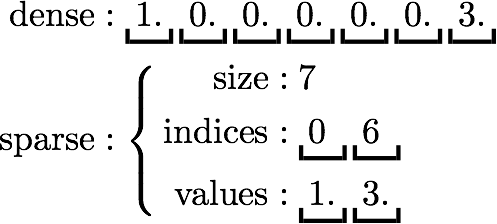

In [18]:
from IPython.display import Image
Image("imagens/vetores.png")

Vetores esparsos: vetores que têm muitos valores como zero. Economia de armazenamento e processamento. 7seg

Vetor denso: maioria dos valores no vetor são diferentes de zero. Desperdício de armazenamento e processamento. 47seg

Conceitualmente são o mesmo objeto. Apenas um vetor. Normalmente, o vetor esparso é representado por uma tupla (id, valor).

Por exemplo, um vetor denso (1, 2, 0, 0, 5, 0, 9, 0, 0) seria representado como vetor esparso assim: {(0,1,4,6), (1, 2, 5, 9)}

## 3 colunas de acordo c/ análise de correlação e passando a um Vetor Denso

In [19]:
# Convertendo para um LabeledPoint (target, Vector[features])
# Remove colunas não relevantes para o modelo ou com baixa correlação

def transformaVar(row) :
    obj = (row["MPG"], Vectors.dense([row["ACCELERATION"], 
                                      row["DISPLACEMENT"], 
                                      row["WEIGHT"]]))
    return obj # Retornar objet

## Criando RDD4

In [20]:
# Utiliza o RDD, aplica a função, converte para Dataframe e aplica a função select()
carrosRDD4 = carrosRDD3.map(transformaVar)

carrosDF = spSession.createDataFrame(carrosRDD4,["label", "features"])

carrosDF.select("label","features").show(10)

+-----+-------------------+
|label|           features|
+-----+-------------------+
| 18.0|[12.0,307.0,3504.0]|
| 15.0|[11.5,350.0,3693.0]|
| 18.0|[11.0,318.0,3436.0]|
| 16.0|[12.0,304.0,3433.0]|
| 17.0|[10.5,302.0,3449.0]|
| 15.0|[10.0,429.0,4341.0]|
| 14.0| [9.0,454.0,4354.0]|
| 14.0| [8.5,440.0,4312.0]|
| 14.0|[10.0,455.0,4425.0]|
| 15.0| [8.5,390.0,3850.0]|
+-----+-------------------+
only showing top 10 rows



In [21]:
carrosRDD4.take(5)

[(18.0, DenseVector([12.0, 307.0, 3504.0])),
 (15.0, DenseVector([11.5, 350.0, 3693.0])),
 (18.0, DenseVector([11.0, 318.0, 3436.0])),
 (16.0, DenseVector([12.0, 304.0, 3433.0])),
 (17.0, DenseVector([10.5, 302.0, 3449.0]))]

---

# A maioria dos Algoritmos em Spark espera atributos/features/variáveis preditoras no formato de Vetor

## Machine Learning

## Dividir o DataFrame em dados de Treino e Teste - randomSplit( )

In [22]:
# Dados de Treino e de Teste
(dados_treino, dados_teste) = carrosDF.randomSplit([0.7, 0.3])

In [23]:
dados_treino.count()

269

In [24]:
dados_teste.count()

129

## Criar modelo/algoritmo de Regressão Linear

In [25]:
# Criação do modelo
linearReg = LinearRegression(maxIter = 10)

## Realizar Treinamento do Modelo

In [ ]:
# Treinamento 
modelo = linearReg.fit(dados_treino)

In [26]:
print(modelo)

LinearRegression_cddcb93ca8a2


# Ao trabalhar c/ a equação, devemos encontrar os Coeficientes e Intercepto

## Imprimir Métricas do Modelo: Coeficientes e Intercepto deste modelo

In [27]:
# Imprimindo as métricas
print("Coeficientes: " + str(modelo.coefficients))
print("Intercepto: " + str(modelo.intercept))

Coeficientes: [0.17687848792596617,-0.016852089036649896,-0.005654367636025606]
Intercepto: 41.00885997075843


## Aplicar o Modelo a novos dados que o modelo ainda desconhece

In [28]:
# Previsões com dados de teste
predictions = modelo.transform(dados_teste) # Aplicando transform ao objeto modelo e passando os Dados de Teste
predictions.select("features", "prediction").show() # Select nas previsões para retornar os atributos e previsões

# O retorno mostra os atributos (valores reais) em relação aos valores previstos do modelo.

+-------------------+------------------+
|           features|        prediction|
+-------------------+------------------+
|[15.0,307.0,4376.0]|13.744933180148355|
|[13.5,318.0,4382.0]|13.260316263040103|
|[11.5,429.0,4952.0]| 7.812987851585433|
|[12.5,400.0,4906.0]| 8.738677832831428|
|[11.0,360.0,3821.0]|15.282432547496253|
|[12.0,400.0,4746.0]|  9.55493741063254|
|[12.0,400.0,5140.0]| 7.327116562038455|
|[13.0,350.0,3988.0]| 14.86043101849841|
|[14.5,350.0,4699.0]|11.105493361173153|
|[16.0,302.0,4294.0]| 14.46973025941167|
| [9.0,454.0,4354.0]|10.330801252197585|
|[11.5,400.0,4464.0]| 11.06102984002878|
|[13.0,318.0,4096.0]|14.789026162980441|
|[13.5,351.0,4154.0]|13.993393145844493|
|[16.0,302.0,4638.0]|12.524627792618858|
|[12.8,351.0,4215.0]|13.524661778498754|
| [9.5,400.0,3761.0]|14.682293312302846|
|[11.0,318.0,3399.0]|18.376363429438356|
|[11.5,350.0,3693.0]|16.263151739237014|
|[12.5,304.0,3892.0]| 16.09000716327978|
+-------------------+------------------+
only showing top

## Avaliar Performance do Modelo c/ RegressionEvaluator( )

- Apontar que as previsões são o objeto "prediction"
- labelcol é a coluna "label", dados históricos reais
- Usar como métrica o coeficiente de Determinação 
- Passar atributos para o "avaliador" e chama a função evaluate


## Coeficiente de Determinação - Quanto maior, melhor.

In [30]:
# Coeficiente de determinação R2
avaliador = RegressionEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "r2")
avaliador.evaluate(predictions)

0.6789639625215236

# Como melhorar a performance do modelo?

- Poderiamos incluir mais variáveis ao invés de 3
- Incluir outra combinação de variáveis
- Aumentar o conjunto de dados para treinamento
- Mudança no split de dados de treino e teste
- Mudança na quantidade de iterações na criação do algoritmo